In [2]:
import os
import time
import shlex
import subprocess
import pickle
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import vaex as vx
import fitsio
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

# Alternative use vaex virtual columns

In [3]:
# add_virtual_columns_eq2gal(long_in='ra', lat_in='dec', long_out='l', lat_out='b', input=None, output=None, name_prefix='__celestial_eq2gal', radians=False)

In [4]:
# It doesn't properly work, because gets zero-filled tables
def fits2h5():
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for filename in filenm:
            if ("Y3A2_COADD_OBJECT_SUMMARY_COORDS_" in filename):
                fits_f = os.path.join(root, filename)
                h5_f = fits_f.replace(".fits", ".hdf5")
                print(h5_f)
                cmd = "vaex convert file {0} {1}".format(fits_f, h5_f)
                cmd = shlex.split(cmd)
                sp = subprocess.Popen(cmd, stdout=subprocess.PIPE)
                outp = sp.communicate()
                sp.wait()
                print(outp)


# Reading the FITS (downloaded using easyaccess or deslabs)

In [5]:
def get_all(pattern, columns=None):
    if (not isinstance(columns, list)):
        print("If no list of keys is input, then all are retrieved")
    tabls = []
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                tabls.append(f)
                hdu = fitsio.FITS(f)
                if counter:
                    if (columns is None):
                        r_arr = hdu[1].read()
                    else:
                        r_arr = hdu[1].read()[columns]
                    counter = False
                else:
                    if (columns is None):
                        r_arr = np.concatenate((r_arr, hdu[1].read()))
                    else:
                        r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                hdu.close()
                print("{0} loaded".format(f))
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

# Plot the entire(!) dataset without using healpix or pre-binning

In [4]:
# Read into vaex. Ok, it's not optimal... better ways are read directly from FITS and h5, and from pandas
aux_all = get_all("Y3A2_COADD_OBJECT_SUMMARY_COORDS_", columns=["L", "B"])

Y3A2_COADD_OBJECT_SUMMARY_COORDS_000001.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000002.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000003.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000004.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000005.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000006.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000007.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000008.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000009.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000010.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000011.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000012.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000013.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000014.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000015.fits loaded
Elapsed time in reading the FITS: 3.66 min


In [5]:
ds = vx.from_arrays(x=aux_all["L"], y=aux_all["B"])
ds.plot_widget("x", "y", 
               colormap="bone_r", 
               xlabel=r"$l_{gal}$", ylabel=r"$b_{gal}$", 
               title="2D map of all objects on the footprint Y3A2",
               limits=((0, 360), (-90, -30)),
              )

A Jupyter Widget

In [12]:
# Free memory
gc.collect()
del aux_all

# Do the statistics for ra,dec -> l,b transformation

## Option 1: do the transformation for a  sub-sample, based on the entire set

### Load data from FITS tables

In [6]:
# Load the data
arr_coo = get_all("Y3A2_COADD_OBJECT_SUMMARY_COORDS_", 
                  columns=["ALPHAWIN_J2000", "DELTAWIN_J2000", "L", "B"]
                 )
print("Data was successfully loaded")

Y3A2_COADD_OBJECT_SUMMARY_COORDS_000001.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000002.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000003.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000004.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000005.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000006.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000007.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000008.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000009.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000010.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000011.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000012.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000013.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000014.fits loaded
Y3A2_COADD_OBJECT_SUMMARY_COORDS_000015.fits loaded
Elapsed time in reading the FITS: 10.98 min
Data was successfully loaded


In [87]:
gc.collect()

0

### Using a subset of the total, transform coordinates using astropy

In [7]:
# Transform for a subset. The astropy function is slow, so use a subsample
aux_idx = np.arange(arr_coo.shape[0])[::5]

In [90]:
t0 = time.time()
eq = SkyCoord(ra=arr_coo["ALPHAWIN_J2000"][aux_idx]*u.degree, 
              dec=arr_coo["DELTAWIN_J2000"][aux_idx]*u.degree, 
              frame='icrs')
print("Ingestion complete")
gal = eq.galactic
t1 = time.time()
print("Transformation complete. Elapsed: {0:.2f} min".format((t1 - t0) / 60.))

Ingestion complete
Transformation complete. Elapsed: 3.44 min


In [8]:
# Overwrite 
arr_coo = arr_coo[aux_idx]

#### Below pickle lines are intended to be executed only in case of need

In [95]:
# For the sake of time, pickle the array
pickle.dump(gal, open("gal.pickle", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load the object
gal = pickle.load(open("gal.pickle", "rb"))

### Check rounding effects of convert (alpha, delta) -> (l, b) -> (alpha, delta)

In [127]:
type(gal.transform_to("icrs"))

astropy.coordinates.sky_coordinate.SkyCoord

In [128]:
eq2 = gal.transform_to("icrs")

In [137]:
ds_check = vx.from_arrays(d_ra=arr_coo["ALPHAWIN_J2000"] - eq2.ra.deg,
                          d_dec=arr_coo["DELTAWIN_J2000"] - eq2.dec.deg
                         )

Text(0.5,1,'RA differences when reverse transform is applied')

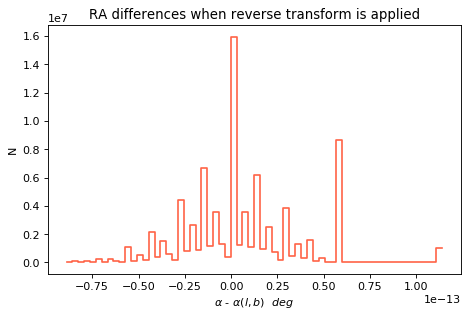

In [153]:
ds_check.plot1d("d_ra", 
                figsize=(6, 4),
                color="tomato",
                xlabel=r"$\alpha$ - $\alpha(l,b)$  $deg$", 
                ylabel="N", 
               )
plt.title("RA differences when reverse transform is applied")

Text(0.5,1,'DEC differences when reverse transform is applied')

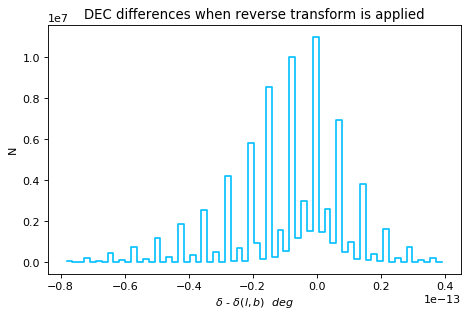

In [155]:
ds_check.plot1d("d_dec",
                figsize=(6, 4),
                color="deepskyblue",
                xlabel=r"$\delta$ - $\delta(l,b)$  $deg$", 
                ylabel="N", 
               )
plt.title("DEC differences when reverse transform is applied")

In [142]:
print("Equivalence of 1e-13 to mas: {0}".format(1e-13*3600*1000))

Equivalence of 1e-13 to mas: 3.6e-07


### Load into vaex

In [11]:
# Read into vaex
ds_gal = vx.from_arrays(L=arr_coo["L"], 
                        B=arr_coo["B"], 
                        L2=np.array(gal.l), 
                        B2=np.array(gal.b))

In [52]:
ds_gal_mas = vx.from_arrays(L=arr_coo["L"] * 3600 *1000, 
                            B=arr_coo["B"] * 3600 *1000, 
                            L2=np.array(gal.l) * 3600 *1000, 
                            B2=np.array(gal.b) * 3600 *1000)

In [12]:
gc.collect()
plt.close("all")

In [13]:
print("Checking the percentage of the total: {0}%".format(round(arr_coo.shape[0] / 4.e8 * 100)))

Checking the percentage of the total: 20%


/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


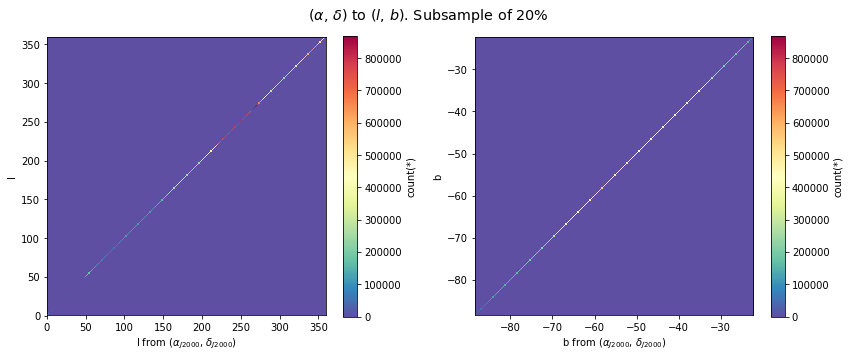

In [14]:
fig, ax1 = plt.subplots(figsize=(8,6))
ds_gal.plot([["L2", "L"], ["B2", "B"]], 
            vmin=1,
            aspect="equal",
            colormap="Spectral_r", 
            background_color='white', 
            figsize=(12,5),
            xlabel=[r"l from ($\alpha_{J2000}$, $\delta_{J2000}$)", r"b from ($\alpha_{J2000}$, $\delta_{J2000}$)"],
            ylabel=["l", "b"],
            title=r"($\alpha$, $\delta$) to ($l$, $b$). Subsample of {0}%".format(round(arr_coo.shape[0] / 4.e8 * 100))
           )
plt.legend()
plt.subplots_adjust(top=0.9)
plt.savefig("lb_comparison_{0}pcent.png".format(round(arr_coo.shape[0] / 4.e8 * 100)), 
            format="png", dpi=500
           )

### Both *l* and *b* together

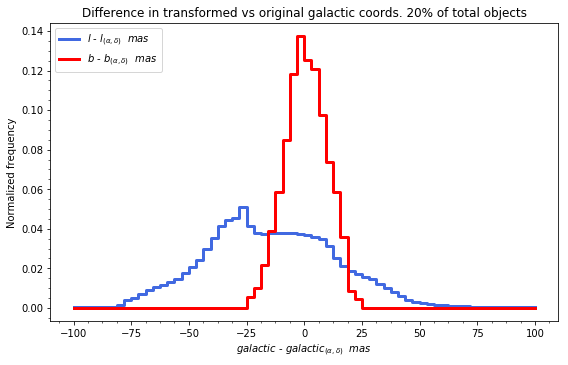

In [109]:
fig, ax = plt.subplots(figsize=(8,5))

lb_lim = [-100, 100]
l = ds_gal_mas.plot1d("L-L2", #figsize=(8,5),
                      n="normalize",
                      limits=lb_lim,
                      label=r"$l$ - $l_{(\alpha, \delta)}$  $mas$",
                      color="royalblue", lw=3
                     )
b = ds_gal_mas.plot1d("B-B2",# figsize=(8,5), # xlabel=r"$b$ - $b_{(\alpha, \delta)}$  $deg$", ylabel="N",
                      limits=lb_lim,
                      xlabel=r"$galactic$ - $galactic_{(\alpha, \delta)}$  $mas$", 
                      ylabel="Normalized frequency",
                      label=r"$b$ - $b_{(\alpha, \delta)}$  $mas$",
                      n="normalize",
                      color="red", lw=3
                     )
# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax.yaxis.set_minor_locator(minorLocator_y)

plt.legend(loc="upper left")
plt.title("Difference in transformed vs original galactic coords. {0}% of total objects".format(round(arr_coo.shape[0] / 4.e8 * 100)))

plt.savefig("l_and_b_hist_{0}pcent.png".format(round(arr_coo.shape[0] / 4.e8 * 100)), 
            format="png", dpi=500
           )

### For *l*

['-270.0', '-180.0', '-90.0', '0.0', '90.0', '180.0', '270.0']


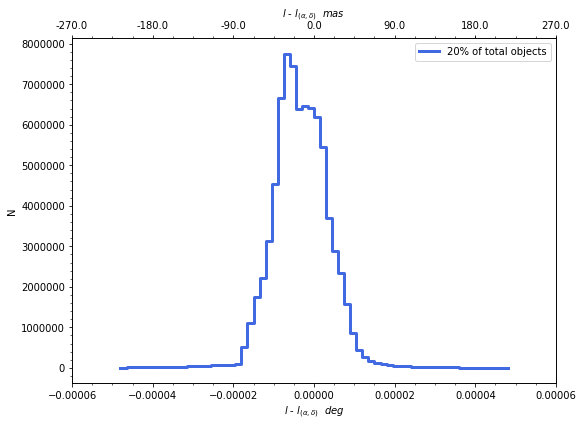

In [105]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()

#IMPORTANT set the limits and use on ax1, ax2 and vaex
lim = [-6e-5, 6e-5] #[-0.1e-4, 0.1e-4]
b = ds_gal.plot1d("L-L2",# figsize=(8,5), # xlabel=r"$b$ - $b_{(\alpha, \delta)}$  $deg$", ylabel="N",
                  limits=lim,
                  label="{0}% of total objects".format(round(arr_coo.shape[0] / 4.e8 * 100)),
                  color="royalblue", lw=3
                 )
plt.legend(loc="upper right")

# Set limits
ax1.set_xlim(lim)
ax1.set_xlabel(r"$l$ - $l_{(\alpha, \delta)}$  $deg$")
ax1.set_ylabel("N")

# New axis locations
new_tick_locations = np.array([-7.5e-5, -5e-5, -2.5e-5, 0, 2.5e-5, 5e-5, 7.5e-5])
def tick_function(x):
    res = x * 3600 * 1000
    return ["%.1f" % z for z in res]

print(tick_function(new_tick_locations))

#  Values and tics
ax2.set_xlim(lim)#[lim[0] * 3600 * 1000, lim[1] * 3600 * 1000])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$l$ - $l_{(\alpha, \delta)}$  $mas$")
#ax2.set_xlim([-6e-7 * 3600 * 1000, 6e-7 * 3600 * 1000]) # plt.xlim())

if True:
    # Use Auto Minor Locator
    minorLocator_x = AutoMinorLocator()
    ax1.xaxis.set_minor_locator(minorLocator_x)
    minorLocator_y = AutoMinorLocator()
    ax1.yaxis.set_minor_locator(minorLocator_y)
    # Use Auto Minor Locator
    minorLocator_x = AutoMinorLocator()
    ax2.xaxis.set_minor_locator(minorLocator_x)
    minorLocator_y = AutoMinorLocator()

#
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.12, right=0.96)
plt.savefig("l_hist_{0}pcent.png".format(round(arr_coo.shape[0] / 4.e8 * 100)), 
            format="png", dpi=500
           )

### For *b*

['-21.6', '-14.4', '-7.2', '0.0', '7.2', '14.4', '21.6']


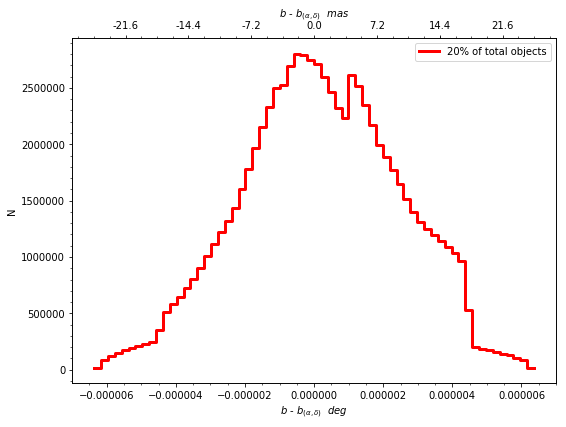

In [106]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()

#IMPORTANT set the limits and use on ax1, ax2 and vaex
lim = [-7e-6, 7e-6]
b = ds_gal.plot1d("B-B2",# figsize=(8,5), # xlabel=r"$b$ - $b_{(\alpha, \delta)}$  $deg$", ylabel="N",
                  limits=lim,
                  label="{0}% of total objects".format(round(arr_coo.shape[0] / 4.e8 * 100)),
                  color="red", lw=3
                 )
plt.legend(loc="upper right")

# Set limits
ax1.set_xlim(lim)
ax1.set_xlabel(r"$b$ - $b_{(\alpha, \delta)}$  $deg$")
ax1.set_ylabel("N")

# New axis locations
new_tick_locations = np.array([-6e-6, -4e-6, -2e-6, 0, 2e-6, 4e-6, 6e-6])
def tick_function(x):
    res = x * 3600 * 1000
    return ["%.1f" % z for z in res]

print(tick_function(new_tick_locations))

#  Values and tics
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$b$ - $b_{(\alpha, \delta)}$  $mas$")
#ax2.set_xlim([-6e-7 * 3600 * 1000, 6e-7 * 3600 * 1000]) # plt.xlim())

# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax1.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax1.yaxis.set_minor_locator(minorLocator_y)
# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax2.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()

#
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.12, right=0.96)
plt.savefig("b_hist_{0}pcent.png".format(round(arr_coo.shape[0] / 4.e8 * 100)), 
            format="png", dpi=500
           )

## Option 2: using astropy tables, for 1 subsample

In [16]:
# Read an unique FITS with astropy tables
from astropy.io import fits
from astropy.table import Table, Column
hdu = fits.open("Y3A2_COADD_OBJECT_SUMMARY_COORDS_000015.fits")
tab = hdu[1].data
tab.names
tnew = Table()

In [17]:
# Transform
c_icrs = SkyCoord(ra=tab["ALPHAWIN_J2000"]*u.degree, dec=tab["DELTAWIN_J2000"]*u.degree, frame='icrs').galactic
print("Transformation complete")

Transformation complete


In [18]:
# Create a lighter table
arr_l, arr_b = np.array(c_icrs.l), np.array(c_icrs.b)
tnew["L"] = tab["L"]
tnew["B"] = tab["B"]
hdu.close()
tnew["L2"] = Column(arr_l, unit="degrees")
tnew["B2"] = Column(arr_b, unit="degrees")

In [19]:
# Import to vaex
ds = vx.from_astropy_table(tnew)

In [20]:
gc.collect()
plt.close("all")

/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


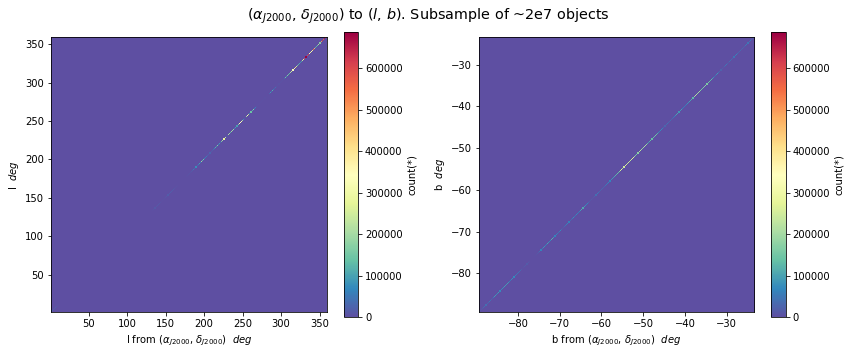

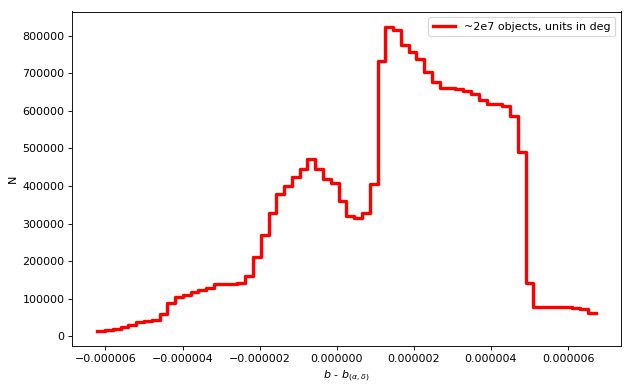

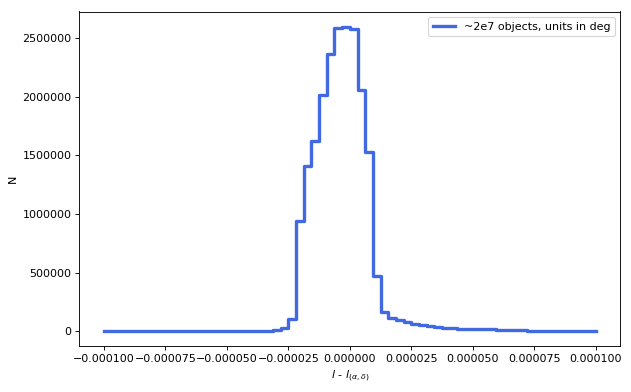

In [21]:
# Do the plots
if True:
    ds.plot([["L2", "L"], ["B2", "B"]], 
            vmin=1,
            aspect="equal",
            colormap="Spectral_r", 
            background_color='white', 
            figsize=(12,5),
            xlabel=[r"l from ($\alpha_{J2000}$, $\delta_{J2000}$)  $deg$", r"b from ($\alpha_{J2000}$, $\delta_{J2000}$)  $deg$"],
            ylabel=["l  $deg$", "b  $deg$"],
            title=r"($\alpha_{J2000}$, $\delta_{J2000}$) to ($l$, $b$). Subsample of ~2e7 objects")
    plt.savefig("lb_comparison_subsample.png", format="png", dpi=500)

    ds.plot1d("B-B2", figsize=(8,5), 
              xlabel=r"$b$ - $b_{(\alpha, \delta)}$", 
              ylabel="N",
              label="~2e7 objects, units in deg",
              color="red", lw=3)
    plt.legend()
    plt.savefig("b_hist_subsample.png", format="png", dpi=500)

    ds.plot1d("L-L2", limits=[-0.0001,0.0001],
              figsize=(8,5), 
              xlabel=r"$l$ - $l_{(\alpha, \delta)}$", 
              ylabel="N",
              label="~2e7 objects, units in deg",
              color="royalblue", lw=3)
    plt.legend()
    plt.savefig("l_hist_subsample.png", format="png", dpi=500)

## Additional: check differences between (alpha, delta) <-> (ra, dec)

In [88]:
coo50 = get_all("DR1_MAIN_COORDS_")

If no list of keys is input, then all are retrieved
DR1_MAIN_COORDS_000001.fits loaded
DR1_MAIN_COORDS_000002.fits loaded
DR1_MAIN_COORDS_000003.fits loaded
Elapsed time in reading the FITS: 0.38 min


In [90]:
print("Checking percentage of total: {0}%".format(round(coo50.shape[0]/4.e8 * 100)))

Checking percentage of total: 13%


In [91]:
coo50.dtype

dtype([('RA', '>f8'), ('DEC', '>f8'), ('ALPHAWIN_J2000', '>f8'), ('DELTAWIN_J2000', '>f8'), ('L', '>f8'), ('B', '>f8'), ('COADD_OBJECT_ID', '>i8')])

In [92]:
ds_tmp = vx.from_arrays(ra=coo50["RA"], dec=coo50["DEC"],
                        alpha=coo50["ALPHAWIN_J2000"], delta=coo50["DELTAWIN_J2000"],
                        diff1=(coo50["RA"]-coo50["ALPHAWIN_J2000"]) * 3600 * 1000,
                        diff2=(coo50["DEC"]-coo50["DELTAWIN_J2000"]) * 3600 * 1000
                       )

### Difference between RA and ALPHAWIN, in *mas*

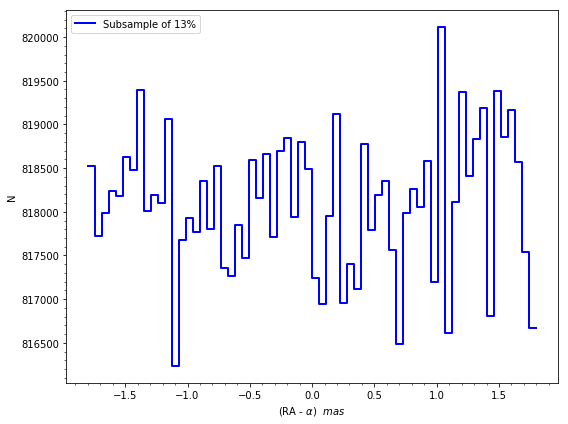

In [107]:
fig, ax1 = plt.subplots(figsize=(8, 6))
kw= {"color":"blue",
     "lw":2,
    }

ds_tmp.plot1d("diff1", 
              xlabel=r"(RA - $\alpha$)  $mas$", 
              ylabel="N", 
              label="Subsample of {0}%".format(round(coo50.shape[0]/4.e8 * 100)),
              **kw
             )
plt.legend()

# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax1.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax1.yaxis.set_minor_locator(minorLocator_y)

plt.savefig("ra_alpha_subsample.png", format="png", dpi=500)

### Difference between DEC and DELTAWIN, in *mas*

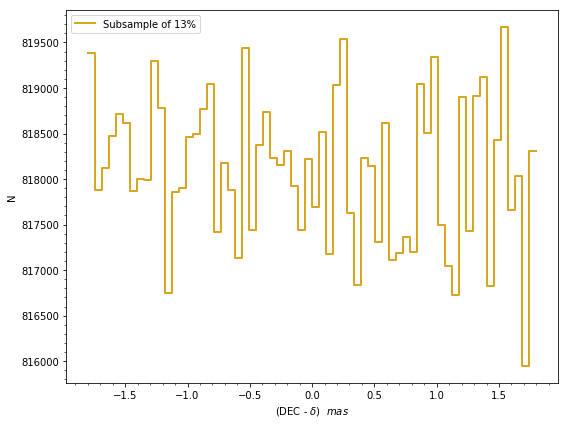

In [108]:
fig, ax1 = plt.subplots(figsize=(8, 6))
kw= {"color":"goldenrod",
     "lw":2,
    }

ds_tmp.plot1d("diff2", 
              xlabel=r"(DEC - $\delta$)  $mas$", 
              ylabel="N", 
              label="Subsample of {0}%".format(round(coo50.shape[0]/4.e8 * 100)),
              **kw
             )
plt.legend()

# Use Auto Minor Locator
minorLocator_x = AutoMinorLocator()
ax1.xaxis.set_minor_locator(minorLocator_x)
minorLocator_y = AutoMinorLocator()
ax1.yaxis.set_minor_locator(minorLocator_y)

plt.savefig("dec_delta_subsample.png", format="png", dpi=500)

# Inverse transformation, from galactic to equatorial

### Setup a galactic coordinates frame and transform it to equatorial

In [110]:
t0 = time.time()
gal_coo = SkyCoord(l=arr_coo["L"]*u.degree, 
                   b=arr_coo["B"]*u.degree, 
                   frame='galactic')
print("Ingestion complete")
eq_coo = gal_coo.icrs
t1 = time.time()
print("Transformation complete. Elapsed: {0:.2f} min".format((t1 - t0) / 60.))

Ingestion complete
Transformation complete. Elapsed: 1.26 min


### Import into vaex

In [119]:
ds_inv_check = vx.from_arrays(diff_ra=(arr_coo["ALPHAWIN_J2000"] - np.array(eq_coo.ra.deg)) * 3600 * 1000,
                              diff_dec=(arr_coo["DELTAWIN_J2000"] - np.array(eq_coo.dec.deg)) * 3600 * 1000
                             )

### Using *mas* scale, plot the differences between original and transformated coordinates

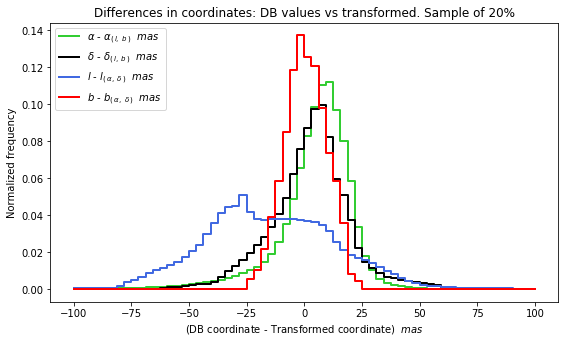

In [137]:
fig, ax1 = plt.subplots(figsize=(8, 5))

kwin = {
    "limits": [-100, 100],
    "n":"normalize",
    "lw":2,
}

i1 = ds_inv_check.plot1d("diff_ra", 
                         label=r"$\alpha$ - $\alpha _{(\,l,\,\, b\,)}$  $mas$",
                         color="limegreen",
                         **kwin
                        )
i2 = ds_inv_check.plot1d("diff_dec", 
                         label=r"$\delta$ - $\delta _{(\,l,\,\, b\,)}$  $mas$",
                         color="black",
                         **kwin
                        )

l = ds_gal_mas.plot1d("L-L2", 
                      label=r"$l$ - $l_{(\,\alpha,\,\, \delta\,)}$  $mas$",
                      color="royalblue",
                      **kwin
                     )
b = ds_gal_mas.plot1d("B-B2",# figsize=(8,5), # xlabel=r"$b$ - $b_{(\alpha, \delta)}$  $deg$", ylabel="N",
                      xlabel="(DB coordinate - Transformed coordinate)  $mas$",
                      ylabel="Normalized frequency",
                      label=r"$b$ - $b_{(\,\alpha,\,\, \delta\,)}$  $mas$",
                      color="red", 
                      **kwin
                     )
plt.legend(loc="upper left")

plt.title("Differences in coordinates: DB values vs transformed. Sample of {0}%".format(round(arr_coo.shape[0] / 4.e8 * 100)))

plt.subplots_adjust(top=0.9)
plt.savefig("diff_coordinates_hist_{0}pcent.png".format(round(arr_coo.shape[0] / 4.e8 * 100)), 
            format="png", dpi=500
           )